In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def compute_histogram(image):
    hist = np.zeros(256, dtype=int)
    for pixel in image.ravel():  # ravel() : flatten to 1D array
        hist[pixel] += 1
    return hist

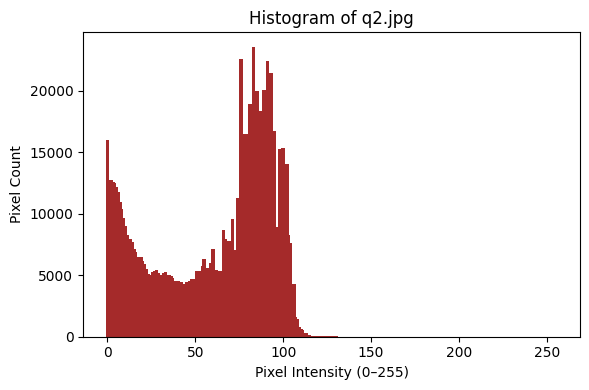

In [3]:
img_gray = cv2.imread('images/q2.jpg', cv2.IMREAD_GRAYSCALE)

hist = compute_histogram(img_gray)

plt.figure(figsize=(6, 4))
plt.bar(np.arange(256), hist, width=2, color='brown')
plt.title("Histogram of q2.jpg")
plt.xlabel("Pixel Intensity (0–255)")
plt.ylabel("Pixel Count")
plt.tight_layout()
plt.show()

### Full Scale Contrast Stretch (FSCS)

#### 演算法公式：

$
I_{\text{out}} = \frac{I - I_{\min}}{I_{\max} - I_{\min}} \times 255
$

- $I_{\min}$：圖像中的最小像素值  
- $I_{\max}$：圖像中的最大像素值  
- 所有像素會被線性映射到 $[0, 255]$，用來提升整體對比

#### 概念：
這種增強方式將整張圖片的像素值進行線性拉伸，將原本落在區間 $[I_{\min}, I_{\max}]$ 的像素值映射到整個輸出區間 $[0, 255]$，\
因此可以更好地分配灰階階調，使暗區變更暗、亮區更亮，提升圖像對比。


In [5]:
def contrast_stretching(image):
    I_min = image.min()
    I_max = image.max()

    # 避免除以 0
    if I_max == I_min:
        return image.copy()

    stretched = (image - I_min) / (I_max - I_min) * 255
    return stretched.astype(np.uint8)

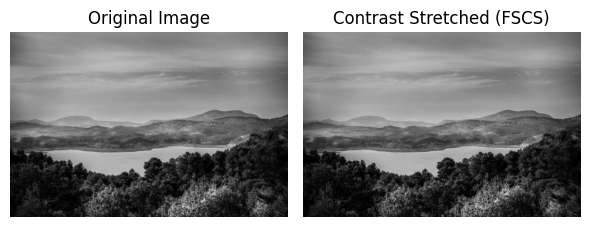

In [6]:
img_stretched = contrast_stretching(img_gray)

# plot
fig, axes = plt.subplots(1, 2, figsize=(6, 4))
axes[0].imshow(img_gray, cmap='gray')
axes[0].set_title("Original Image")
axes[0].axis('off')

axes[1].imshow(img_stretched, cmap='gray')
axes[1].set_title("Contrast Stretched (FSCS)")
axes[1].axis('off')

plt.tight_layout()
plt.show()

### Logarithmic Contrast Compression – 原理與公式

Logarithmic Contrast Compression 是一種非線性映射技術，用來壓縮高亮區域的像素值，使整體亮度分布更平均，尤其能提升低亮區的細節。

#### 數學公式：

對於輸入影像中每個像素值 $I \in [0, 255] $，我們應用以下對數轉換公式：

$
I_{\text{out}} = c \cdot \log(1 + I)
$

其中係數 $c$ 用來將輸出映射回 $[0, 255]$ 範圍，定義為：

$
c = \frac{255}{\log(1 + I_{\max})}
$

- $+1 $ 是為了避免 $\log(0)$ 

#### 使用情境：
- 原圖亮度範圍偏窄或集中於高亮（overexposed）
- 想讓暗部細節更明顯

#### 效果：
- 暗部（低值）被「拉開」→ 細節更明顯
- 亮部（高值）被「壓縮」→ 減少過曝
- 影像動態範圍變得更平衡

In [8]:
def log_contrast_compression(image):
    image_float = image.astype(np.float32)
    c = 255 / np.log(1 + image_float.max())
    compress = c * np.log(1 + image_float)
    
    # compress = np.log(1 + image_float)
    return np.clip(compress, 0, 255).astype(np.uint8)

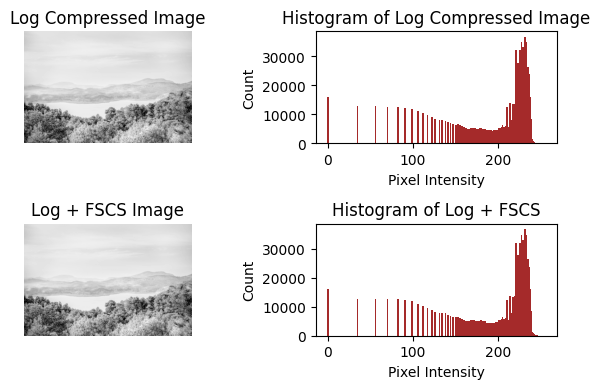

In [9]:
# Apply log compression
img_log = log_contrast_compression(img_gray)

# Apply FSCS to log-compressed image
img_log_fscs = contrast_stretching(img_log)

# Compute histograms
hist_log = compute_histogram(img_log)
hist_log_fscs = compute_histogram(img_log_fscs)

# Plot results
fig, axes = plt.subplots(2, 2, figsize=(6,4))

# Log compressed image
axes[0, 0].imshow(img_log, cmap='gray')
axes[0, 0].set_title("Log Compressed Image")
axes[0, 0].axis('off')

# Histogram of log compressed
axes[0, 1].bar(np.arange(256), hist_log, width=2, color='brown')
axes[0, 1].set_title("Histogram of Log Compressed Image")
axes[0, 1].set_xlabel("Pixel Intensity")
axes[0, 1].set_ylabel("Count")

# FSCS after log compression
axes[1, 0].imshow(img_log_fscs, cmap='gray')
axes[1, 0].set_title("Log + FSCS Image")
axes[1, 0].axis('off')

# Histogram after log compression + FSCS
axes[1, 1].bar(np.arange(256), hist_log_fscs, width=2, color='brown')
axes[1, 1].set_title("Histogram of Log + FSCS")
axes[1, 1].set_xlabel("Pixel Intensity")
axes[1, 1].set_ylabel("Count")

plt.tight_layout()
plt.show()


Since the logarithmic compression includes a scaling constant $c = \frac{255}{\log(1 + I_{\max})}$, \
the output already spans the full $[0, 255]$ range, making subsequent FSCS redundant.

### Gamma Correction

#### 數學公式
$
I_{out} = 255 \cdot (\frac{I}{255})^\gamma 
$

In [14]:
def gamma_correction(image, gamma):
    image_normal = image.astype(np.float32) / 255.0
    correct = 255*(image_normal**gamma)
    return np.clip(correct, 0, 255).astype(np.uint8)

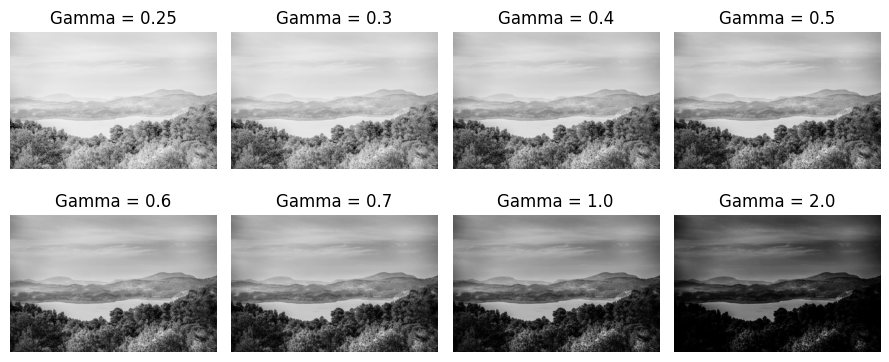

In [17]:
gamma_values = [0.25, 0.3, 0.4, 0.5, 0.6, 0.7, 1.0, 2.0]
correct_images = [gamma_correction(img_gray, gamma) for gamma in gamma_values]

fig, axes = plt.subplots(2, 4, figsize=(9, 4))
for ax, img, gamma in zip(axes.flatten() , correct_images, gamma_values):
    ax.imshow(img, cmap='gray')
    ax.set_title(f"Gamma = {gamma}")
    ax.axis('off')

plt.tight_layout()
plt.show()

####  $\gamma = 0.4$ is pretty well !
It provided the most visually balanced result, enhancing details in the dark regions without overexposing the bright areas.


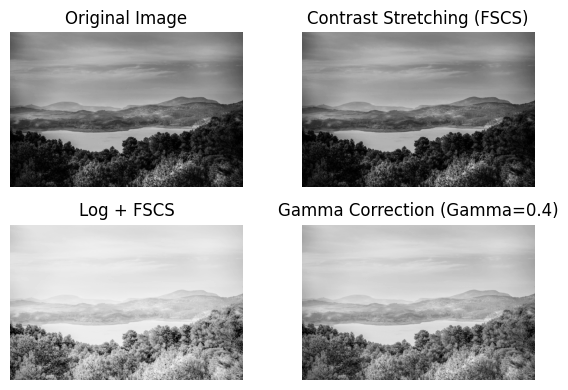

In [21]:
# choose gamma = 0.4
img_gamma = gamma_correction(img_gray, gamma=0.4)

titles = [
    "Original Image",
    "Contrast Stretching (FSCS)",
    "Log + FSCS",
    "Gamma Correction (Gamma=0.4)"
]
images = [
    img_gray,
    img_stretched,
    img_log_fscs,
    img_gamma
]

# plot
fig, axes = plt.subplots(2, 2, figsize=(6, 4))
for ax, img, title in zip(axes.flat, images, titles):
    ax.imshow(img, cmap='gray')
    ax.set_title(title)
    ax.axis('off')

plt.tight_layout()
plt.show()


#### Among the four images, the "Gamma Correction" with $\gamma = 0.4$  provides a more balanced improvement, enhancing visibility in dark areas while keeping bright regions natural.
##### Overall, it offers the best trade-off between visibility and naturalness for the q2.jpg image.

##### Log + FSCS result brings out the most details in the shadows and highlights, making it visually the most dramatic.
##### However, it slightly over-brightens some regions.